In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import math
from src.OpfModel import add_opf_constraints
from src.ThermalModel import add_indoor_constraints
from src.HHPmodel import add_hhp_constraints
from src.Model import build_model
from src.ModelConfig import Config, save_model_info
from src.Parameter import get_model_inf

In [ ]:
model_inf = get_model_inf()
Time_day =96

0.96

In [ ]:

m,dict_optimizedResults = build_model(Time_day,model_inf, add_opf_constraints, add_hhp_constraints, add_indoor_constraints)



Set parameter Username
Set parameter LicenseID to value 2617326
Academic license - for non-commercial use only - expires 2026-02-03
Optimization Runtime: 11.157999992370605 seconds
Model solved successfully!


In [ ]:
# Initialize configuration (custom directory and file settings)
cfg = Config(output_dir="Config", save_lp=False, save_sol=False, save_ilp=False)
# Save model information based on the configuration
save_model_info(m, cfg)

In [5]:
#change the output name

# print(dict_optimizedResults)
Result_p = dict_optimizedResults["p"]
Result_q = dict_optimizedResults["q"]
Result_v= dict_optimizedResults["v_value"]
Result_hp = dict_optimizedResults["p_hp"]
Result_pv_down = dict_optimizedResults["p_pv_down"]
Result_pv = dict_optimizedResults["p_pv"]
Result_T_ind = dict_optimizedResults["T_ind"]
Result_g_boil = dict_optimizedResults["g_boil"]
Result_PPD = dict_optimizedResults["PPD"]

In [7]:
print("total power")
print(Result_p[0])
print("Indoor Tem:")
print(Result_T_ind)
print("Gas:")
print(sum(np.array(Result_g_boil)))
print("hp:")
# print(Result_hp)
print(sum(np.array(Result_hp)))
print("PPD:")
print(Result_PPD)

total power
[-0.016142810789865115, -0.015936669221803226, -0.015952823583990056, -0.015998109438251206, -0.01609365731810724, -0.01592770255305634, -0.015930641296690314, -0.016029984774391604, -0.010831924816492955, -0.015956577295731567, -0.015963846430080014, -0.01602031396858177, -0.01707467050482412, -0.01908906460292452, -0.019372649411672885, -0.01940598345704461, -0.019359842369826488, -0.01941660830599123, -0.019303576557811557, -0.018461373323614243, -0.018014752653282524, -0.017892772997609756, -0.017994433749165553, -0.01730468158379986, -0.01669699536374992, -0.018569193279602558, -0.021065156828166984, -0.018065057166387333, -0.017276159557914873, -0.020163289220540646, -0.01731965118966632, -0.017270038400657703, -0.018124837559601575, -0.017825522596177666, -0.017855337614070696, -0.017763979796792614, -0.012082927446080907, -0.010714145504773674, -0.013510431595760833, -0.01292916959882972, -0.01645478768313339, -0.016473989623871053, -0.016172471152988917, -0.0165158

In [183]:
print(f"The optimal objective value is: {m.objVal}")

The optimal objective value is: 1144.222756733108


In [10]:
Result_p_array = np.array(Result_p)
Result_q_array = np.array(Result_q)

# Result_hp_array = np.array(Result_hp)
# Result_hp_sum = Result_hp_array.sum(axis=0)*1e3  

# Result_hp_down_array = np.array(Result_hp_down)
# Result_hp_down_sum = Result_hp_down_array.sum(axis=0)*1e3  

# Result_pv_array = np.array(Result_pv)
# Result_pv_sum = Result_pv_array.sum(axis=0)*1e3  

# Result_pv_down_array = np.array(Result_pv_down)
# Result_pv_down_sum = Result_pv_down_array.sum(axis=0)*1e3  


In [11]:
#pf validate

import pandas as pd
from pandapower.plotting import simple_plot 
import pandapower as pp



def epse_feeder(t):

    net = pp.create_empty_network()
    pp.set_user_pf_options(net, algorithm='nr', init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles = True) 
    n_bus = 87
    # create buses
    for i in range(n_bus): 
        globals()['b{}'.format(i)] = pp.create_bus(net, 0.23, name = "b{}".format(i))          
    # slack bus
    pp.create_ext_grid(net, globals()['b0'], s_sc_max_kva=400,rx_max=0.1,r0x0_max= 0.1,x0x_max=1.0)
    # create standard lines
    # data from Vision
 
    pp.create_std_type(net, {"c_nf_per_km": 430, "r_ohm_per_km": 1.91, "x_ohm_per_km": 0.096,\
                             "c0_nf_per_km": 260, "r0_ohm_per_km": 4.65, "x0_ohm_per_km": 0.16,\
                             "max_i_ka": 0.075}, name = "16Al", element = "line")

    pp.create_std_type(net, {"c_nf_per_km": 540, "r_ohm_per_km": 0.641, "x_ohm_per_km": 0.085,\
                             "c0_nf_per_km": 320, "r0_ohm_per_km": 1.65, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.14}, name = "50Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 660, "r_ohm_per_km": 0.32, "x_ohm_per_km": 0.082,\
                             "c0_nf_per_km": 400, "r0_ohm_per_km": 0.91, "x0_ohm_per_km": 0.15,\
                             "max_i_ka": 0.22}, name = "95Al", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 200, "r_ohm_per_km": 3.061, "x_ohm_per_km": 0.1,\
                             "c0_nf_per_km": 120, "r0_ohm_per_km": 7.82, "x0_ohm_per_km": 0.18,\
                             "max_i_ka": 0.055}, name = "6Cu", element = "line")
    pp.create_std_type(net, {"c_nf_per_km": 350, "r_ohm_per_km": 1.15, "x_ohm_per_km": 0.08,\
                             "c0_nf_per_km": 210, "r0_ohm_per_km": 3.6, "x0_ohm_per_km": 0.21,\
                             "max_i_ka": 0.1}, name = "16Cu", element = "line")

    
    #use the default cable parameter, next time change it as the gaia Inom
    for i in range(n_bus-1):
        pp.create_line(net, globals()['b{}'.format(network.at[i,'StartNode'])], \
                       globals()['b{}'.format(network.at[i,'EndNode'])], network.at[i,'Length']*1E-3, network.at[i,'cable']) 
        
    # create loads
    for i in range(n_bus): 
        if i in connect1['Node'].values:            
            pp.create_load(net, globals()['b{}'.format(i)], p_mw=Result_p_array[i][t], q_mvar=Result_q_array[i][t])
 
    # print(net.bus)
    # print(net.line)
    pp.runpp(net)
    # simple_plot(net, plot_loads = True)  
    p_bus0 = net.res_bus.loc[0, 'p_mw']  # Active power at bus 0
    q_bus0 = net.res_bus.loc[0, 'q_mvar']  # Reactive power at bus 0
    
    return net, p_bus0, q_bus0

if __name__ == "__main__":
    TransAva=[]
    PFdiff =[]
    PF_bus0=[]
    for t in range(Time_day):
        net,p_bus0,q_bus0 = epse_feeder(t)
        # add p_bus0 to the list
        PF_bus0.append(p_bus0)
        # TransAva.append(p_bus0 - congestion_limit[t])
        # PFdiff.append(abs(p_bus0 - Result_p_array[0][t]))
        
        

In [ ]:
LoadPower.iloc[:,1:]
#help me sum the load power
LoadPower.iloc[:,1:].sum(axis=1)

array([-0.01556154])

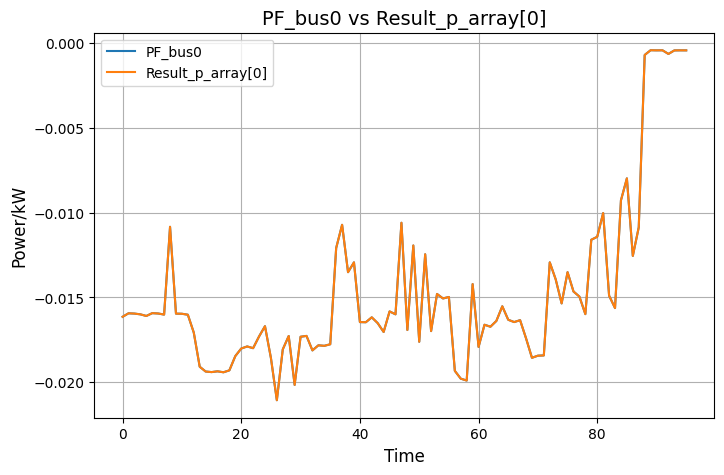

In [12]:
# compare PF_bus0 with Result_p_array[0] in every time step in a plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(PF_bus0, label='PF_bus0')
plt.plot(Result_p_array[0], label='Result_p_array[0]')
# add sum (Result_p_array[i] for i in range(1, n_bus)) to the plot
# plt.plot(-sum(Result_p_array[i] for i in range(1, n_bus)), label='Sum of Result_p_array[i]')
#plot the total load power in every time step
# plt.plot(-LoadPower.iloc[:,1:].sum(axis=1).values*1E-3, label='Total Load Power')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power/kW', fontsize=12)
plt.title('PF_bus0 vs Result_p_array[0]', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


In [136]:
#check the transformer's power 
min_value = min(TransAva)
max_value = max(PFdiff)
# Check if the transformer power of the pf fit the congestion limit
if min_value < 0:    
    locations = [i for i, val in enumerate(TransAva) if val == min_value]
    print(f"Congestion Management Error: {min_value}")
    print(f"Locations of Errors: {locations}")
#calculate the difference between the pf and opf
print(f"The power flow validate the OPF result, the biggest difference is: {max_value}MW")

The power flow validate the OPF result, the biggest difference is: 3.656321740340418e-07MW
